In [1]:
from datetime import datetime
import settings.config as cfg
import pandas as pd
import numpy as np


preprocessed_dataset_folder = cfg.preprocessed_dataset_folder
individual_rs_strategy = cfg.individual_rs_strategy
aggregation_strategies = cfg.aggregation_strategies
recommendations_number = cfg.recommendations_number
individual_rs_validation_folds_k = cfg.individual_rs_validation_folds_k
group_rs_evaluation_folds_k = cfg.group_rs_evaluation_folds_k
evaluation_strategy = cfg.evaluation_strategy
metrics = cfg.metrics
group_types = cfg.group_types

display(cfg.dataset_folder,cfg.preprocessed_dataset_folder)

'ml-1m'

'preprocessed_dataset'

In [2]:
import pandas as pd
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")

import pickle

group_composition = pickle.load(open(preprocessed_dataset_folder+"/group_composition.pkl", "rb"))
len(group_composition)

240

## Train individual RS / Prepare groundtruth
- it is expected, that individual RS are already trained and stored in pkl

# Compare recommendations for individual users
- get user pairs
- assess their actual similarity w.r.t. ratings
- check their similarity w.r.t. recommended items
- display w.r.t. similarity

In [3]:
#select pairs of users and state their similarity
# count of pairs = 10000
pairs_count = 10000
users = pd.Series(ratings_df.user.unique())
u1 = users.sample(pairs_count, replace=True, random_state = 42)
u2 = users.sample(pairs_count, replace=True, random_state = 24)
pairs_df = pd.DataFrame({"u1":u1.values, "u2":u2.values})
pairs_df = pairs_df.loc[pairs_df.u1 != pairs_df.u2]
pairs_df

,u1,u2
0,861,4515
1,5391,900
2,5227,344
3,5192,3474
4,3773,2194
...,...,...
9995,308,1327
9996,2139,3738
9997,3465,1785
9998,4898,48


In [4]:
# computing similarity between each pair of users

import numpy as np

user_matrix = ratings_df.pivot_table(columns='item', index='user', values='rating')

user_id_set = set(ratings_df['user'])
user_id_indexes = user_matrix.index.values
user_matrix = user_matrix.fillna(0)
numpy_array = user_matrix.to_numpy()
sim_matrix = np.corrcoef(numpy_array)


In [5]:
similarities = []
for (idx, row) in pairs_df.iterrows():
    user_1_index = user_id_indexes.tolist().index(row["u1"])
    user_2_index = user_id_indexes.tolist().index(row["u2"])
    similarities.append(sim_matrix[user_1_index][user_2_index])
pairs_df["sim_ratings"] = similarities
pairs_df

,u1,u2,sim_ratings
0,861,4515,-0.020145
1,5391,900,0.053610
2,5227,344,0.055848
3,5192,3474,0.123120
4,3773,2194,0.055799
...,...,...,...
9995,308,1327,0.119256
9996,2139,3738,0.062793
9997,3465,1785,0.066651
9998,4898,48,0.130673


In [6]:
import math
def jaccard_sim(a,b):
    return len(a.intersection(b))/len(a.union(b))

topk = 20
idcg = pd.Series([(1/math.log2(i+2))**2 for i in range(topk)]).sum()

def process_fold(pairs_df, test_pred_df):
    import math
    jaccardSim = []
    twinDCGSim = []

    
    for (idx, g) in pairs_df.iterrows():
        userData1 = test_pred_df.loc[test_pred_df.user == g["u1"]].sort_values("predicted_rating", ascending=False).iloc[:topk]
        userData2 = test_pred_df.loc[test_pred_df.user == g["u2"]].sort_values("predicted_rating", ascending=False).iloc[:topk]

        userItems1 = set(userData1.item.values)
        userItems2 = set(userData2.item.values)
        jaccardSim.append(jaccard_sim(userItems1, userItems2))

        userData1["weight"] = [1/math.log2(i+2) for i in range(len(userData1))]
        userData2["weight_r"] = [1/math.log2(i+2) for i in range(len(userData2))]
        userData1 = userData1.set_index("item")
        userData2 = userData2.set_index("item")

        userData = userData1.join(userData2, how="inner", rsuffix="_r")
        userData["weightTot"] = userData["weight"]*userData["weight_r"]

        twinDCGSim.append(userData["weightTot"].sum()/idcg)

        if idx % 1000 == 0:
            print("done "+str(idx))
            
    return (jaccardSim,twinDCGSim)


In [7]:
#select pairs of users and state their similarity
# count of pairs = 10000
pairs_df_final = pairs_df.copy()
import os
import warnings
warnings.filterwarnings('ignore')
lst = os.listdir(preprocessed_dataset_folder)
#folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]
folds = ["fold_0"]
recommenders = ["LENSKIT_ALS","LENSKIT_CF_USER", "LENSKIT_CF_ITEM"]
for f in folds:
    for r in recommenders:
        current_fold = int(f.replace("fold_",""))
        path_to_fold = preprocessed_dataset_folder+"/"+f
        path_to_recommender = path_to_fold+"/"+r

        test_pred_df = pickle.load(open(path_to_recommender+"/test_pred_df.pkl", "rb"))

        (jaccardSim,twinDCGSim) = process_fold(pairs_df, test_pred_df)   

        pairs_df_final[r+"_jc_"+str(current_fold)] = jaccardSim
        pairs_df_final[r+"_dcg_"+str(current_fold)] = twinDCGSim
    break




done 0
done 1000
done 2000
done 3000
done 4000
done 5000
done 6000
done 7000
done 8000
done 9000
done 0
done 1000
done 2000
done 3000
done 4000
done 5000
done 6000
done 7000
done 8000
done 9000
done 0
done 1000
done 2000
done 3000
done 4000
done 5000
done 6000
done 7000
done 8000
done 9000


In [8]:
pairs_df_final

,u1,u2,sim_ratings,LENSKIT_ALS_jc_0,LENSKIT_ALS_dcg_0,LENSKIT_CF_USER_jc_0,LENSKIT_CF_USER_dcg_0,LENSKIT_CF_ITEM_jc_0,LENSKIT_CF_ITEM_dcg_0
0,861,4515,-0.020145,0.666667,0.855861,0.250000,0.499354,0.212121,0.211818
1,5391,900,0.053610,0.481481,0.748926,0.212121,0.284786,0.250000,0.584459
2,5227,344,0.055848,0.481481,0.691834,0.142857,0.225110,0.250000,0.459515
3,5192,3474,0.123120,0.290323,0.497515,0.250000,0.286007,0.081081,0.096943
4,3773,2194,0.055799,0.600000,0.843197,0.212121,0.432680,0.176471,0.276144
...,...,...,...,...,...,...,...,...,...
9995,308,1327,0.119256,0.333333,0.599852,0.176471,0.316087,0.176471,0.302633
9996,2139,3738,0.062793,0.481481,0.822865,0.290323,0.413611,0.250000,0.414797
9997,3465,1785,0.066651,0.538462,0.609501,0.379310,0.527331,0.333333,0.566462
9998,4898,48,0.130673,0.212121,0.552124,0.142857,0.230451,0.081081,0.094246


In [9]:
bins = [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
pairs_df_final["bins"] = np.digitize(pairs_df_final.sim_ratings,bins)
pairs_df_final

,u1,u2,sim_ratings,LENSKIT_ALS_jc_0,LENSKIT_ALS_dcg_0,LENSKIT_CF_USER_jc_0,LENSKIT_CF_USER_dcg_0,LENSKIT_CF_ITEM_jc_0,LENSKIT_CF_ITEM_dcg_0,bins
0,861,4515,-0.020145,0.666667,0.855861,0.250000,0.499354,0.212121,0.211818,1
1,5391,900,0.053610,0.481481,0.748926,0.212121,0.284786,0.250000,0.584459,2
2,5227,344,0.055848,0.481481,0.691834,0.142857,0.225110,0.250000,0.459515,2
3,5192,3474,0.123120,0.290323,0.497515,0.250000,0.286007,0.081081,0.096943,3
4,3773,2194,0.055799,0.600000,0.843197,0.212121,0.432680,0.176471,0.276144,2
...,...,...,...,...,...,...,...,...,...,...
9995,308,1327,0.119256,0.333333,0.599852,0.176471,0.316087,0.176471,0.302633,3
9996,2139,3738,0.062793,0.481481,0.822865,0.290323,0.413611,0.250000,0.414797,2
9997,3465,1785,0.066651,0.538462,0.609501,0.379310,0.527331,0.333333,0.566462,2
9998,4898,48,0.130673,0.212121,0.552124,0.142857,0.230451,0.081081,0.094246,3


In [10]:
pairs_df_final.groupby("bins").mean()

,u1,u2,sim_ratings,LENSKIT_ALS_jc_0,LENSKIT_ALS_dcg_0,LENSKIT_CF_USER_jc_0,LENSKIT_CF_USER_dcg_0,LENSKIT_CF_ITEM_jc_0,LENSKIT_CF_ITEM_dcg_0
bins,,,,,,,,,
0,2719.000000,896.500000,-0.109076,0.380952,0.630150,0.126984,0.293191,0.161616,0.211578
1,3035.514812,3024.951161,-0.016540,0.454521,0.630144,0.168878,0.281766,0.148003,0.251474
2,3046.321807,3003.123326,0.049323,0.445625,0.622479,0.177983,0.297686,0.152186,0.258590
3,3010.262676,2977.263380,0.143008,0.444094,0.618572,0.183854,0.308375,0.160579,0.271951
4,3041.207895,3046.684211,0.237979,0.452961,0.627442,0.191439,0.318555,0.170063,0.283502
5,2909.044776,3002.455224,0.332406,0.460513,0.614736,0.182688,0.297012,0.185577,0.293406
6,3120.181818,4044.818182,0.436733,0.487612,0.648175,0.212255,0.373929,0.216265,0.352076


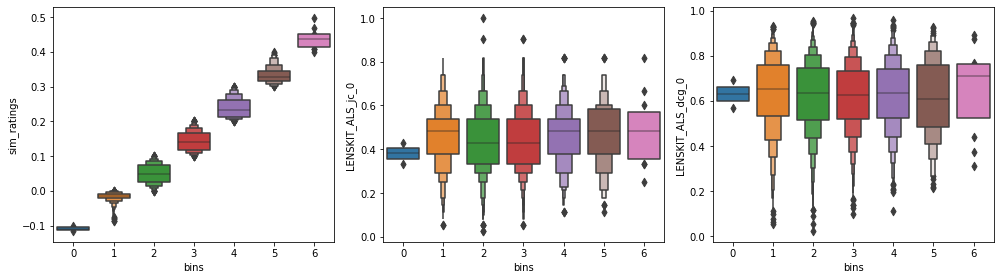

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,3, figsize=(14,4))

sns.boxenplot(data=pairs_df_final, x="bins", y="sim_ratings", ax=ax[0])
sns.boxenplot(data=pairs_df_final, x="bins", y="LENSKIT_ALS_jc_0", ax=ax[1])
sns.boxenplot(data=pairs_df_final, x="bins", y="LENSKIT_ALS_dcg_0", ax=ax[2])
plt.tight_layout()

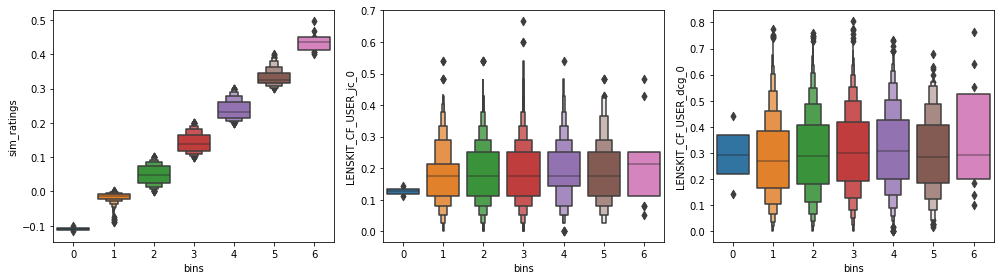

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,3, figsize=(14,4))

sns.boxenplot(data=pairs_df_final, x="bins", y="sim_ratings", ax=ax[0])
sns.boxenplot(data=pairs_df_final, x="bins", y="LENSKIT_CF_USER_jc_0", ax=ax[1])
sns.boxenplot(data=pairs_df_final, x="bins", y="LENSKIT_CF_USER_dcg_0", ax=ax[2])
plt.tight_layout()

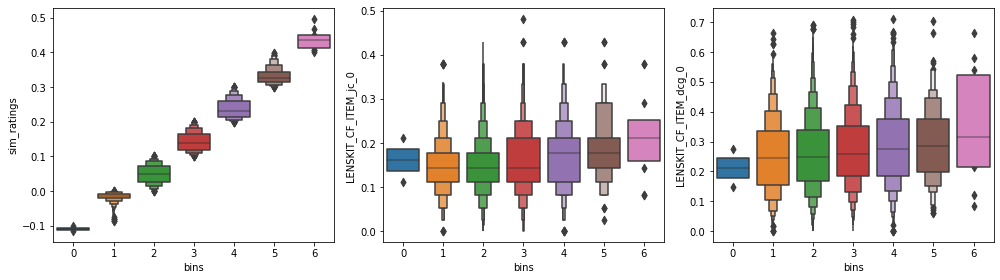

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,3, figsize=(14,4))

sns.boxenplot(data=pairs_df_final, x="bins", y="sim_ratings", ax=ax[0])
sns.boxenplot(data=pairs_df_final, x="bins", y="LENSKIT_CF_ITEM_jc_0", ax=ax[1])
sns.boxenplot(data=pairs_df_final, x="bins", y="LENSKIT_CF_ITEM_dcg_0", ax=ax[2])
plt.tight_layout()

# Evaluate nDCG of each algorithm


In [15]:
from lenskit import batch, topn, util
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg,name='ndcg')
rla.add_metric(topn.ndcg,name='ndcg_20', k=20)
rla.add_metric(topn.hit,name='hit_20', k=20)

folds = ["fold_0"]
recommenders = ["LENSKIT_ALS","LENSKIT_CF_USER", "LENSKIT_CF_ITEM"]
for f in folds:
    for r in recommenders:
        current_fold = int(f.replace("fold_",""))
        path_to_fold = preprocessed_dataset_folder+"/"+f
        path_to_recommender = path_to_fold+"/"+r
        test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
        test_pred_df = pickle.load(open(path_to_recommender+"/test_pred_df.pkl", "rb"))
        
        test_pred_df.columns=["user","item","rating"]
        test_pred_df = test_pred_df.sort_values(["user","rating"], ascending=False)
        
        
        results = rla.compute(test_pred_df, test_df)
        print(r)
        print(results.mean())
    

#mean_res = results.reset_index().groupby(["Algorithm","Params"]).mean()["ndcg"]

LENSKIT_ALS
nrecs      2019.000000
ndcg          0.335915
ndcg_20       0.080772
hit_20        0.571026
dtype: float64
LENSKIT_CF_USER
nrecs      2019.000000
ndcg          0.336584
ndcg_20       0.083891
hit_20        0.543543
dtype: float64
LENSKIT_CF_ITEM
nrecs      2019.000000
ndcg          0.348374
ndcg_20       0.106408
hit_20        0.619371
dtype: float64
